# 2.0 Napari

## Simple setup

To use the `src` module inside of the notebooks:

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import ast
import napari
import src # Load custom functions.
import shapely
import shapely.ops

import numpy as np
import pandas as pd
import shapely.geometry as geometry

from collections import OrderedDict
from dask_image.imread import imread
from skimage.measure import label

## Initalize an empty Napari Viewer

In [3]:
%gui qt5
viewer = napari.Viewer()

## Display channels

In [4]:
display_specification = OrderedDict(
    GFP_mask = dict(colormap="cyan"),
    GFP = dict(colormap="green"),
    DsRed = dict(colormap="red"),
    # DIC = dict(colormap="gray", visible=True, opacity=0.2),
) 
display_specification

OrderedDict([('GFP_mask', {'colormap': 'cyan'}),
             ('GFP', {'colormap': 'green'}),
             ('DsRed', {'colormap': 'red'})])

In [5]:
channels_stacks = {
    path.stem: imread(path.joinpath("*.tif"))
    for path in src.data_dir("sample", "tif", "xy02").glob("*")
    if path.is_dir() and path.stem in display_specification
}
channels_stacks

{'DsRed': dask.array<_map_read_frame, shape=(25, 512, 640), dtype=uint16, chunksize=(1, 512, 640), chunktype=numpy.ndarray>,
 'GFP_mask': dask.array<_map_read_frame, shape=(25, 512, 640), dtype=uint8, chunksize=(1, 512, 640), chunktype=numpy.ndarray>,
 'GFP': dask.array<_map_read_frame, shape=(25, 512, 640), dtype=uint16, chunksize=(1, 512, 640), chunktype=numpy.ndarray>}

In [6]:
%gui qt5

for name in reversed(display_specification):
    viewer.add_image(
        data=channels_stacks[name],
        name=name,
        blending="additive",
        contrast_limits=[0, 2000],
        multiscale=False,
        **display_specification[name]
    )

In [7]:
%gui qt5
viewer.add_labels(
        data=channels_stacks["GFP_mask"].map_blocks(label).compute(),
        name="labels",
        blending="additive"
)

<Labels layer 'labels' at 0x1577c2190>

## Read and transform roi's pickle files.

In [8]:
roi_files = sorted(
    src.data_dir("sample", "data_cells_tracked", "xy02", "normData").glob("*.pkl")
)

tracked_cells_df = (
    # Read pickle files into a single data frame.
    pd.DataFrame(
        dict(
            list_str_cells = [pd.read_pickle(file) for file in roi_files]
        )
    )
    # Each observation is a list of strings.
    # Convertet to long format.
    .explode(column="list_str_cells")
    # Each string is a set of variables delimited by tab.
    .list_str_cells
    .str.rstrip("\t")
    .str.split(r"\t+", expand=True) # One column per variable.
    .reset_index()
    # Indicate actual column values.
    .rename(columns = {
        "index": "frame",
        0: "id",
        1: "color",
        2: "roi_id",
        3: "track_id",
        4: "roi_polygon",
        5: "center",
        6: "axis",
        7: "GFP",
        8: "DsRed",
        9: "dead",
        10: "previous_frame",
        11: "next_frame",
        12: "mother_id"
    })
    # Transfrom shape-strings columns into geometries.
    .assign(
        roi_polygon=lambda df: df.roi_polygon.apply(ast.literal_eval).apply(geometry.Polygon),
        center=lambda df: df.center.apply(ast.literal_eval).apply(geometry.Point),
        axis=lambda df: df.axis.apply(ast.literal_eval).apply(geometry.LineString)
    )
    # Swap coordinates since napari and ImageJ has inverted axes.
    .assign(
        roi_polygon=lambda df: df.roi_polygon.apply(
            lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon)
        )
    )
    # Transform polygons to fit napari conditions.
    .assign(
        napari_polygon=lambda df: df.apply(
            lambda df_row: np.array([[df_row.frame, x, y] for (x, y) in df_row.roi_polygon.exterior.coords]), 
            axis=1)
    )
)

tracked_cells_df.head(1)

,frame,id,color,roi_id,track_id,roi_polygon,center,axis,GFP,DsRed,dead,previous_frame,next_frame,mother_id,napari_polygon
0,0,20.0,#abcdcd,roi_f20_n0_x234_y409,[],"POLYGON ((410 238, 410 239, 411 239, 411 240, ...",POINT (233.6920667302324 410.6278959176846),LINESTRING (246.9999999999999 430.683093054870...,587.0,98.795,0,[],[],[],"[[0.0, 410.0, 238.0], [0.0, 410.0, 239.0], [0...."


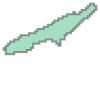

In [9]:
tracked_cells_df.roi_polygon.to_list()[0]

## Include cells shapes into viewer

In [10]:
# %gui qt5

# n = 100
# sub_df = tracked_cells_df[0:n]
# properties = sub_df[["id", "roi_id", "GFP", "DsRed", "dead", "previous_frame", "next_frame"]].to_dict(orient="list")

# viewer.add_shapes(
#     data=sub_df.napari_polygon,
#     metadata=properties,
#     text="{roi_id}",
#     shape_type="polygon",
#     name="rois"
# )

In [36]:
from skimage.measure import grid_points_in_poly

images_shape = channels_stacks["GFP_mask"].shape[1:]
np.unique(ord_enc.fit_transform(tracked_cells_df[["roi_id"]]))

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.357e+03, 4.358e+03,
       4.359e+03])

In [32]:
(
    tracked_cells_df
    .select_columns(["frame", "roi_id", "roi_polygon"])
    .assign(roi_id = lambda df: ord_enc.fit_transform(df.roi_id))
    .groupby(["roi_id"])
    .size()
    .reset_index(name="n")
    #.assign(roi_polygon = lambda df: df.roi_polygon.apply(lambda polygon: grid_points_in_poly(images_shape, np.array(polygon.exterior.coords)).shape))
)

ValueError: Expected 2D array, got 1D array instead:
array=['roi_f20_n0_x234_y409' 'roi_f20_n1_x286_y383' 'roi_f20_n2_x374_y417' ...
 'roi_f44_n126_x177_y359' 'roi_f44_n127_x173_y308'
 'roi_f44_n128_x184_y262'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [31]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()

In [19]:
(
    tracked_cells_df
    .select_columns(["frame", "roi_id", "roi_polygon"])
    .assign(roi_polygon = lambda df: df.roi_polygon.apply(lambda polygon: grid_points_in_poly(images_shape, np.array(polygon.exterior.coords)).shape))
)

,frame,roi_id,roi_polygon
0,0,roi_f20_n0_x234_y409,"(512, 640)"
1,0,roi_f20_n1_x286_y383,"(512, 640)"
2,0,roi_f20_n2_x374_y417,"(512, 640)"
3,0,roi_f20_n3_x399_y407,"(512, 640)"
4,0,roi_f20_n4_x244_y386,"(512, 640)"
...,...,...,...
4355,24,roi_f44_n124_x226_y75,"(512, 640)"
4356,24,roi_f44_n125_x214_y55,"(512, 640)"
4357,24,roi_f44_n126_x177_y359,"(512, 640)"
4358,24,roi_f44_n127_x173_y308,"(512, 640)"
